In [1]:
#path = 'saved_model_1001_1' #epoch 60 / 20  large image x3
#path = 'saved_model_1001_softmax_RMSprop_80_30' Not bad, little noisy.
#path = 'saved_model_1001_softmax_RMSprop_100_30_0.0001' #less noisy but stamp not really good
#path = 'saved_models/saved_model_1001_softmax_RMSprop_100_40_0.0005' #less noisy. stamp better.
#path = 'saved_model_1001_softmax_Adam_100_40_0.0005' #little bit worse
#path = 'saved_model_1005_softmax_RMSprop_100_40_0.0005_with_classweights'
#path = 'saved_model_1005_softmax_RMSprop_100_30_0.0005_B8_with_classweights'
#path = 'saved_model_1005_softmax_RMSprop_50_30_0.0005_B16_with_classweights_100'
#path = 'saved_model_1005_RMSprop_100_0.0005_B1_classweights_P5_S10'
#path = 'saved_model_1005_RMSprop_80_0.0005_BNone_classweights_P5_S30'
#path = 'saved_model_1006_Adam_70_0.0005_BNone_classweights_P5_S50'
#path = 'saved_model_1006_RMSprop_70_0.0005_BNone_classweights_P86_S3055'
#path = 'saved_model_1006_RMSprop_130_0.0005_BNone_classweights_P86_S3059'
#path = 'saved_model_1006_RMSprop_150_0.0005_BNone_classweights_P86_S3056_EncoderTrained'
#path = 'saved_model_1006_RMSprop_100_0.0005_BNone_classweights_P86_S3056_EncoderTrained'
path = 'saved_model_1006_RMSprop_100_0.0001_BNone_classweights_P86_S3057_EncoderTrained'

In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from IPython.display import clear_output
import matplotlib.pyplot as plt

#import segmentation_models as sm

import numpy as np
from numpy import genfromtxt
import matplotlib
from matplotlib import pyplot
from matplotlib.image import imread

import glob
import cv2
import gc

from tqdm import tqdm
import time

2.2.0


In [3]:
"""
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
"""

Found GPU at: /device:GPU:0


In [4]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Ground Truth Mask', 'Pushed', 'Stamped']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    #plt.savefig("EX_1.png")
    plt.axis('off')

  plt.show()

In [5]:
def create_mask(pred_mask, num=0):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[num]

def show_predictions(test_mode=False, x=None,y=None, num=1):
  if test_mode:
    print("In testing Mode...")
    for i in range(num):
      pred_mask = model.predict(x, batch_size=1)
      display([x[i], y[i], create_mask(pred_mask, num=i)])

  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

  

In [317]:
def draw_and_count(img, contours, label = '', draw_type = '', show=True):
    # img : original image
    # contours: Contours found from opencv code
    assert label in ['push', 'stamp'], "label must be either 'push' or 'stamp'"
    assert draw_type in ['bbox', 'contour'], "draw type must be either 'bbox' or 'contour'"
    
    if label=='push': val = 220
    if label=='stamp': val = 150
        
    count = 0
    area = []
    width_height = []
    
    for idx, cnt in enumerate(contours):
        a = cv2.contourArea(cnt)
        if a < val:
            continue
        
        area.append(a)
        count += 1
        
        if draw_type == 'bbox':
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(img,(x,y),(x+w,y+h),(125,125,0),2)
            width_height.append([w,h])
            print("{} #{} has width of {} and height of {}".format(label, idx, w, h))
            
        elif draw_type == 'contour':
            cv2.drawContours(img, [cnt], 0, (125, 125, 0), 2) 
            
    if show:        
        display([img])
        print("{} {} found. Area: {}".format(count,label,area))

        
    return pushed_x, area, width_height, count

In [6]:
mask = imread('images/test/gt_mask/일반7__분리막 눌림_검정.png') #2048 x 2448

colors = np.unique(tf.reshape(mask,[-1,3]), axis=0)

color_dict = {i: list(x) for i,x in enumerate(colors)}
print(color_dict)

def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros(shape, dtype=np.int8)
    for i, cls in enumerate(color_dict):
        arr[:, :, i] = np.all(rgb_arr.reshape((-1, 3)) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

{0: [0.0, 0.0, 0.0], 1: [0.9607843, 0.5764706, 0.19215687], 2: [0.98039216, 0.19607843, 0.3254902], 3: [0.98039216, 0.98039216, 0.21568628]}


In [251]:
model = tf.keras.models.load_model(path)

# WITHOUT TRT

In [255]:
time_list = []
pred_mask = []

for idx,image in enumerate(tqdm(glob.glob("images/train/*/*.bmp"))):
    start = time.time()
    
    n = cv2.imread(image)
    n = tf.cast(n, tf.float32) / 255.0
    image = tf.image.resize(n, (480,576)) #960,1152
    
    image = tf.expand_dims(image,0)
    pred_mask.append(model(image)) # N, H, W, 3
    
    ex = pred_mask[idx][0]
    
    pushed = np.round(tf.expand_dims(ex[:,:,1], -1))+np.round(tf.expand_dims(ex[:,:,2], -1))
    circle = np.round(tf.expand_dims(ex[:,:,3], -1))
    stamped = np.round(tf.expand_dims(ex[:,:,2], -1))
    
    stamped_x = stamped.astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    closed_stamp = cv2.dilate(stamped_x, k)
    contours, hierarchy = cv2.findContours(closed_stamp, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    stamp_img, stamp_area, wh, stamp_count = draw_and_count(stamped_x, contours, stamp=True, show=False)
    
    pushed_x = pushed.astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
    closing = cv2.morphologyEx(pushed_x, cv2.MORPH_CLOSE, k)
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    push_img, push_area, wh, pushed_count = draw_and_count(pushed_x, contours, push=True, show=False)
    
    #print("Sample #{} has {} stamps and {} pushes. Stamp areas: {}, Push areas: {}".format(idx, stamp_count, pushed_count, 
    #                                                                                 stamp_area, push_area))
    
    time_list.append(time.time()-start)
    
print("Average inference time is: ", (np.mean(time_list) * 1000).round(3), "ms")
#print(time_list)

100%|██████████| 46/46 [00:03<00:00, 13.02it/s]

Average inference time is:  76.25435227933137 ms
[0.09303140640258789, 0.076873779296875, 0.07739639282226562, 0.07482504844665527, 0.08326077461242676, 0.08370494842529297, 0.07242155075073242, 0.07796788215637207, 0.07756805419921875, 0.0794827938079834, 0.08075642585754395, 0.07636141777038574, 0.07335972785949707, 0.07248735427856445, 0.07750463485717773, 0.07446074485778809, 0.07876443862915039, 0.0717320442199707, 0.0736091136932373, 0.07623696327209473, 0.0774538516998291, 0.07484745979309082, 0.0773935317993164, 0.07489275932312012, 0.07837414741516113, 0.07239103317260742, 0.07305502891540527, 0.07527494430541992, 0.07637548446655273, 0.06894946098327637, 0.06921601295471191, 0.07290816307067871, 0.07660841941833496, 0.07849454879760742, 0.07297992706298828, 0.07418680191040039, 0.07391166687011719, 0.07457470893859863, 0.07396268844604492, 0.07329893112182617, 0.08179664611816406, 0.07320499420166016, 0.0791010856628418, 0.07832074165344238, 0.07616543769836426, 0.07815623283

In [256]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

In [257]:
# Load converted model and infer
model = tf.saved_model.load(path, tags=[trt.tag_constants.SERVING])
graph_func = model.signatures[trt.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
frozen_func = trt.convert_to_constants.convert_variables_to_constants_v2(graph_func)

In [267]:
time_list = []
pred_mask = []

img_loc = glob.glob("images/train/*/*.bmp")
    
    
for idx,image in enumerate(tqdm(img_loc)):
    
    start = time.time()
    
    n = cv2.imread(image)
    n = tf.cast(n, tf.float32) / 255.0
    image = tf.image.resize(n, (480,576)) #960,1152
    
    flipped = tf.image.flip_left_right(image)
    
    image = tf.expand_dims(flipped,0)
    pred_mask.append(frozen_func(image)) # N, H, W, 3
    
    ex = pred_mask[idx][0][0]
    pushed = np.round(tf.expand_dims(ex[:,:,1], -1))+np.round(tf.expand_dims(ex[:,:,2], -1))
    circle = np.round(tf.expand_dims(ex[:,:,3], -1))
    stamped = np.round(tf.expand_dims(ex[:,:,2], -1))
    
    # STAMP
    stamped_x = stamped.astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    closed_stamp = cv2.dilate(stamped_x, k)
    contours, hierarchy = cv2.findContours(closed_stamp, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    stamp_img, stamp_area, wh, stamp_count = draw_and_count(stamped_x, contours, stamp=True, show=False)
    
    # PUSH
    pushed_x = pushed.astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
    closing = cv2.morphologyEx(pushed_x, cv2.MORPH_CLOSE, k)
    
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    push_img, push_area, wh, pushed_count = draw_and_count(pushed_x, contours, push=True, show=False)


    #print("Sample #{} has {} stamps and {} pushes. Stamp areas: {}, Push areas: {}".format(idx, stamp_count, pushed_count, 
    #                                                                                  stamp_area, push_area))
    
    time_list.append(time.time()-start)
    
print("Average inference time is: ",(np.mean(time_list) * 1000).round(3), "ms")
#print(time_list)

 13%|█▎        | 6/46 [00:00<00:01, 24.26it/s]

Sample #0 has 1 stamps and 4 pushes. Stamp areas: [246.5], Push areas: [1694.0, 2319.0, 2545.5, 3399.0]
Sample #1 has 1 stamps and 1 pushes. Stamp areas: [171.5], Push areas: [3143.0]
Sample #2 has 0 stamps and 1 pushes. Stamp areas: [], Push areas: [3936.5]
Sample #3 has 1 stamps and 3 pushes. Stamp areas: [1199.0], Push areas: [8809.5, 6035.5, 3233.0]
Sample #4 has 2 stamps and 4 pushes. Stamp areas: [659.0, 368.5], Push areas: [2302.5, 2439.0, 7932.5, 6550.5]
Sample #5 has 2 stamps and 4 pushes. Stamp areas: [183.0, 641.5], Push areas: [4551.0, 2392.0, 2854.5, 3528.5]


 26%|██▌       | 12/46 [00:00<00:01, 26.43it/s]

Sample #6 has 0 stamps and 4 pushes. Stamp areas: [], Push areas: [390.0, 550.5, 1846.5, 1616.0]
Sample #7 has 1 stamps and 2 pushes. Stamp areas: [453.5], Push areas: [2250.0, 3309.0]
Sample #8 has 0 stamps and 4 pushes. Stamp areas: [], Push areas: [1264.0, 2120.5, 1422.5, 1786.5]
Sample #9 has 0 stamps and 2 pushes. Stamp areas: [], Push areas: [1582.5, 1562.0]
Sample #10 has 3 stamps and 3 pushes. Stamp areas: [662.0, 173.0, 202.0], Push areas: [1923.5, 9168.5, 820.0]
Sample #11 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []


 39%|███▉      | 18/46 [00:00<00:01, 26.74it/s]

Sample #12 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #13 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #14 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #15 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #16 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #17 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []


 52%|█████▏    | 24/46 [00:00<00:00, 26.52it/s]

Sample #18 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #19 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #20 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #21 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #22 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #23 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []


 65%|██████▌   | 30/46 [00:01<00:00, 27.01it/s]

Sample #24 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #25 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #26 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #27 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #28 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #29 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []


 78%|███████▊  | 36/46 [00:01<00:00, 27.49it/s]

Sample #30 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #31 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #32 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #33 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #34 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []
Sample #35 has 0 stamps and 0 pushes. Stamp areas: [], Push areas: []


 91%|█████████▏| 42/46 [00:01<00:00, 28.00it/s]

Sample #36 has 2 stamps and 4 pushes. Stamp areas: [666.0, 352.5], Push areas: [1916.0, 1968.0, 7734.5, 6266.5]
Sample #37 has 2 stamps and 4 pushes. Stamp areas: [252.0, 600.5], Push areas: [4159.5, 2247.5, 2622.5, 2758.5]
Sample #38 has 0 stamps and 4 pushes. Stamp areas: [], Push areas: [403.5, 526.5, 1551.0, 994.5]
Sample #39 has 0 stamps and 3 pushes. Stamp areas: [], Push areas: [834.0, 370.0, 734.0]
Sample #40 has 1 stamps and 2 pushes. Stamp areas: [187.0], Push areas: [1048.0, 428.5]
Sample #41 has 0 stamps and 1 pushes. Stamp areas: [], Push areas: [1842.5]


100%|██████████| 46/46 [00:01<00:00, 27.19it/s]

Sample #42 has 1 stamps and 2 pushes. Stamp areas: [380.5], Push areas: [2240.0, 2074.5]
Sample #43 has 0 stamps and 4 pushes. Stamp areas: [], Push areas: [1032.0, 1927.5, 1578.0, 1632.5]
Sample #44 has 0 stamps and 2 pushes. Stamp areas: [], Push areas: [1520.5, 1566.0]
Sample #45 has 2 stamps and 3 pushes. Stamp areas: [672.0, 210.5], Push areas: [1948.0, 8468.0, 877.0]
Average inference time is:  36.407 ms


In [12]:
gc.collect()

train_x = []
train_y = []

for img in glob.glob("images/train/*/*.bmp"):
    
    n = cv2.imread(img)
    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, (480,576)) #960,1152

    flipped = tf.image.flip_left_right(n)

    train_x.append(flipped)

    dir = "/".join(img.split("/")[:-1]) + "/gt_mask/"
    file_name = img.split("/")[-1].split('.')[0]

    y = imread(dir+file_name+".png")

    a = rgb_to_onehot(y, color_dict) #change to one hot

    bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot
    bbb = tf.image.resize(bb, (480,576)) #960,1152
    flipped2 = tf.image.flip_left_right(bbb)

    train_y.append(flipped2)

test_x = tf.convert_to_tensor(train_x)
test_y = tf.convert_to_tensor(train_y)

print(test_x.shape)
print(test_y.shape)

(46, 480, 576, 3)
(46, 480, 576, 1)


Ground truth numbers:
1.   black_ng:
1, 2/1, 3, 4, 4/2, 4/2, 3/1, 1, 1, 4/1
3/3, 2, 4/1, 3/1
2.   silver_ng:
4, 4/1, 4/2, 3/1, 1, 1/1, 4/1,
3/2, 2, 4, 2/1




In [13]:
print(np.shape(pred_mask[0][0][0]))

(480, 576, 4)


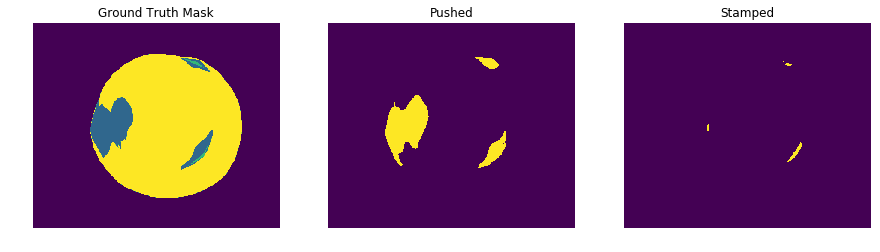

In [322]:
idx = 10

ex = pred_mask[idx][0][0]
pushed = np.round(tf.expand_dims(ex[:,:,1], -1))+np.round(tf.expand_dims(ex[:,:,2], -1))
circle = np.round(tf.expand_dims(ex[:,:,3], -1))
stamped = np.round(tf.expand_dims(ex[:,:,2], -1))

display([test_y[idx],pushed,stamped])
#cv2.imwrite("stamped.png", stamped)

#display([tf.expand_dims(ex[:,:,1], -1), tf.expand_dims(ex[:,:,3], -1), tf.expand_dims(ex[:,:,2], -1)])

In [323]:
stamped_x = stamped.astype(np.uint8) * 255
k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
closed_stamp = cv2.dilate(stamped_x, k)

stamp #0 has width of 39 and height of 52
stamp #1 has width of 8 and height of 28
stamp #2 has width of 25 and height of 16


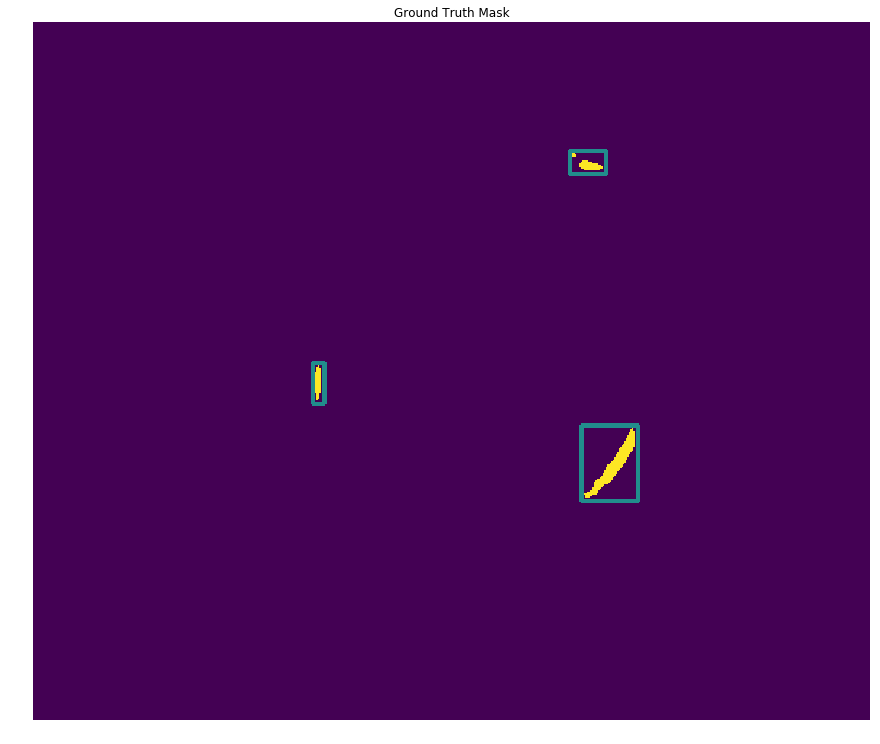

3 stamp found. Area: [662.0, 173.0, 202.0]


In [324]:
contours, hierarchy = cv2.findContours(closed_stamp, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
img, area, wh, count = draw_and_count(stamped_x, contours, label="stamp", draw_type='bbox')

In [311]:
pushed_x = pushed.astype(np.uint8) * 255
k = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
closing = cv2.morphologyEx(pushed_x, cv2.MORPH_CLOSE, k)

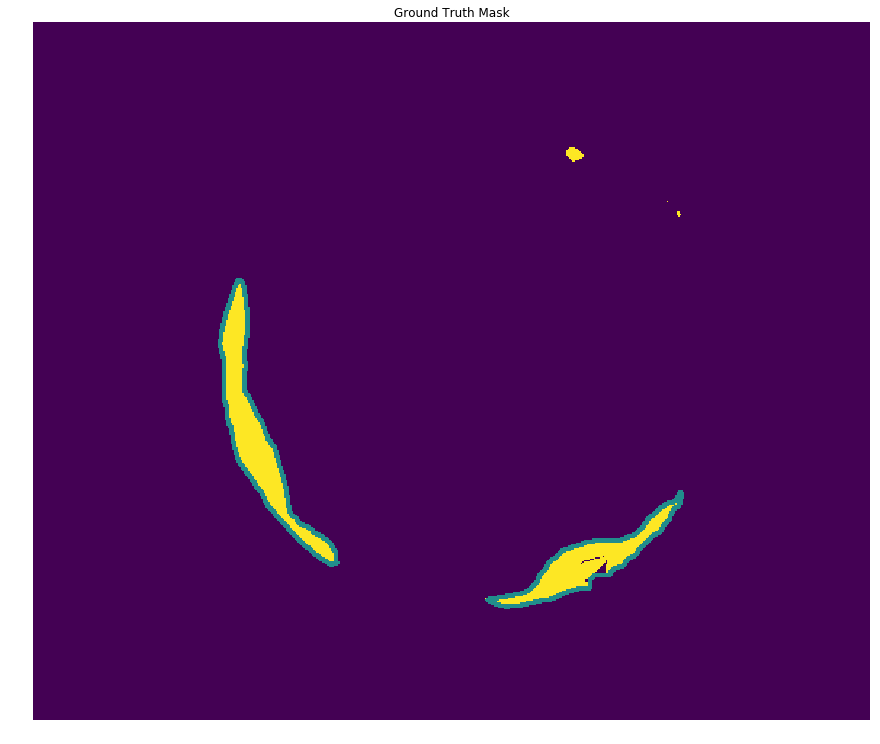

2 push found. Area: [2250.0, 3309.0]


In [312]:
contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
img, area, wh, count = draw_and_count(pushed_x, contours, label='push', draw_type='contour')